<font size=6>Ocean Data Analysis - Analyzing Sea Surface Temperature w/ Variational Inference</font>

Interesting Research
https://www.nature.com/articles/s41467-018-08066-0

In [1]:
import warnings
warnings.filterwarnings('ignore')

import xarray as xr
!pip install netcdf4
import numpy as np 
import pandas as pd 
import matplotlib.pyplot as plt 

import sklearn 
import sklearn.mixture as mix 
import scipy.stats as stats 

import seaborn as sns
sns.set()

In [2]:
# Buoy in Gulf of Maine
ds = xr.open_dataset('https://dods.ndbc.noaa.gov/thredds/dodsC/data/stdmet/44007/44007.ncml')
ds = ds.sel(time=slice('2021-3-30','2023-5-12'))
print(ds)

# Get buoy data from NOAA
noaa_df = ds.to_dataframe().reset_index()
print(noaa_df)

<xarray.Dataset>
Dimensions:                  (latitude: 1, longitude: 1, time: 109632)
Coordinates:
  * latitude                 (latitude) float32 43.53
  * longitude                (longitude) float32 -70.14
  * time                     (time) datetime64[ns] 2021-03-30 ... 2023-04-30T...
Data variables: (12/13)
    wind_dir                 (time, latitude, longitude) float64 ...
    wind_spd                 (time, latitude, longitude) float32 ...
    gust                     (time, latitude, longitude) float32 ...
    wave_height              (time, latitude, longitude) float32 ...
    dominant_wpd             (time, latitude, longitude) timedelta64[ns] ...
    average_wpd              (time, latitude, longitude) timedelta64[ns] ...
    ...                       ...
    air_pressure             (time, latitude, longitude) float32 ...
    air_temperature          (time, latitude, longitude) float32 ...
    sea_surface_temperature  (time, latitude, longitude) float32 ...
    dewpt_tem

In [28]:
# Get sea surface temps
cov = noaa_df[['time','sea_surface_temperature']]
cov = cov.dropna().reset_index().drop(columns=['index'])
#cov['sea_surface_temperature'] = cov['sea_surface_temperature'].rolling(24*6).mean()
#cov = cov.dropna()
print(cov)

                      time  sea_surface_temperature
0      2021-03-30 00:00:00                      5.1
1      2021-03-30 00:10:00                      5.1
2      2021-03-30 00:20:00                      5.1
3      2021-03-30 00:30:00                      5.1
4      2021-03-30 00:40:00                      5.1
...                    ...                      ...
109000 2023-04-30 23:10:00                      6.6
109001 2023-04-30 23:20:00                      6.6
109002 2023-04-30 23:30:00                      6.6
109003 2023-04-30 23:40:00                      6.6
109004 2023-04-30 23:50:00                      6.6

[109005 rows x 2 columns]


In [29]:
# Fit mixture model 
num_components = 2
dpgmm_model = mix.BayesianGaussianMixture(
    n_components=num_components, 
    weight_concentration_prior_type='dirichlet_process',
    n_init=1,
    max_iter=100)
p = dpgmm_model.fit_predict(cov['sea_surface_temperature'].to_numpy().reshape(-1,1))

# Count States
state_counts = np.zeros(num_components)
for M in p:
  state_counts[M] += 1 
print(state_counts)

[44161. 64844.]


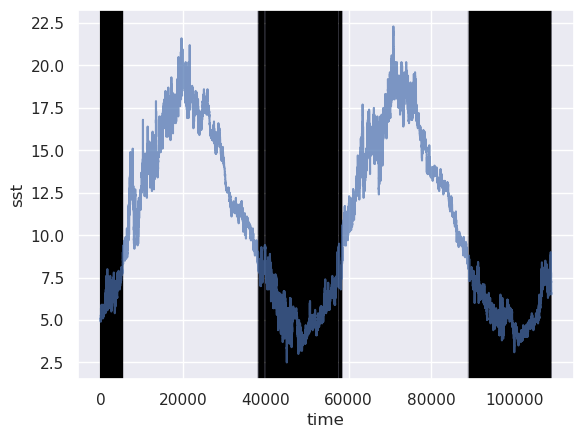

In [30]:
# Plot States
fig2, ax2=plt.subplots()

for M in range(len(p)): 
  if p[M] == p[-1]:
    ax2.axvline(M, color='black', alpha=0.002) 
    
sns.lineplot(data=cov['sea_surface_temperature'].values, ax=ax2, alpha=0.7)
plt.ylabel('sst')
plt.xlabel('time')
plt.show()

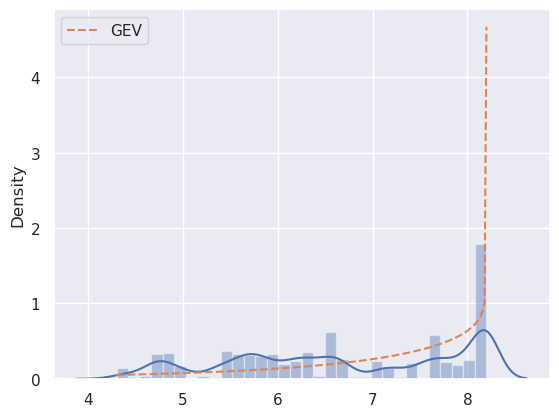

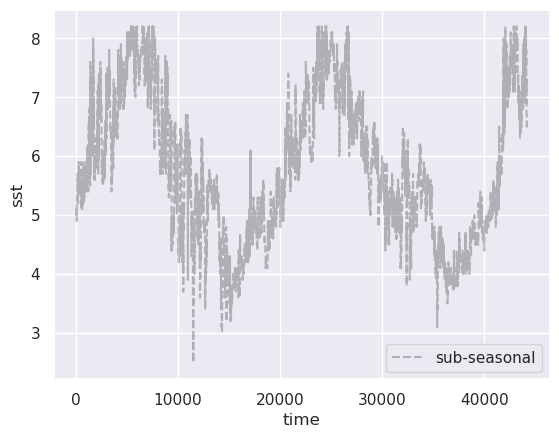

--score--
4.67118448205396


In [39]:
# Plot a gumbel GEV distribution (block maxima approach)
data = []
gev = []

# Apply block maxima
win_len = 1000
block_maxima = lambda serie:[ max(serie[Bl-win_len:Bl]) for Bl in range(win_len, len(serie)) ]
for M in range(len(p)): 
  if p[M] == p[-1]:
    v = cov['sea_surface_temperature'].values[M]
    data.append(v)

# Fit GEV
gev = block_maxima(data)
gev_fit = stats.genextreme.fit(gev)
x = np.linspace(min(gev), max(gev), 200)

# GEV 
fig,ax = plt.subplots()
sns.distplot(gev)
plt.plot(x, stats.genextreme.pdf(x, *gev_fit), linestyle='--', label='GEV')
plt.legend()
plt.show()

# sub-seasonal data 
sns.lineplot(data=data, color='black', alpha=0.25, linestyle='--', label='sub-seasonal')
plt.ylabel('sst')
plt.xlabel('time')
plt.show()

# score the most recent block maxima 
print('--score--')
print(stats.genextreme.pdf(gev[-1], *gev_fit))